# NueCC selection
Jupyter notebook to look at the outcome of the optical selection, with a focus on electrons

## Imports

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, clear_output
import pandas as pd
pd.set_option('display.max_columns', 500)

In [3]:
%autoreload

## Constants

In [4]:
gr = 1.618
outdir= './output/NueCC/'
inputdir = './input/'  

In [5]:
lower = [-1.55, -115.53, 0.1]
upper = [254.8, 117.47, 1036.9]
fidvol_arr = [10,10,10,10,10,50] 

In [6]:
file_name = inputdir+'flashID_tree.root'

## Definitions

In [7]:
def inTPC_df(df, str_x, str_y, str_z, fidvol=[0]*6):
    global upper, lower
    mask_x = df[str_x].between(lower[0]+fidvol[0], upper[0]-fidvol[1])
    mask_y = df[str_y].between(lower[1]+fidvol[2], upper[1]-fidvol[3])
    mask_z = df[str_z].between(lower[2]+fidvol[4], upper[2]-fidvol[5])
    mask = mask_x & mask_y & mask_z
    return mask

def eventHash(df):
    return df.apply(lambda x: hash(tuple(x)), axis = 1)

## Loading inputs

In [8]:
file_flashid = uproot.open(file_name)['pandoraFlashEventBuilding/events']
file_nuecc = uproot.open(file_name)['nueCCAnalyser']

In [9]:
nuecc_events = file_nuecc['Event']
nuecc_daughters = file_nuecc['Daughters']

In [10]:
num_events = file_flashid.numentries
num_selected = nuecc_events.numentries
print("Selection efficiency of nueCC without mc fiducial volume")
print("Number of events:", num_events)
print("Number of passed events:", num_selected)
err = np.sqrt(num_selected*(num_events-num_selected)/num_events**3)
print("Selected: ({0:.1f}+-{1:.1f})%".format(num_selected/num_events*100, err*100))

Selection efficiency of nueCC without mc fiducial volume
Number of events: 25
Number of passed events: 12
Selected: (48.0+-10.0)%


In [11]:
print("Selection efficiency of nueCC with mc fiducial volume")
flashid_vtx_mc = file_flashid.pandas.df(['nuVertexX', 'nuVertexY', 'nuVertexZ'])
flashid_events_fiducial_mc =  inTPC_df(flashid_vtx_mc, 'nuVertexX', 'nuVertexY', 'nuVertexZ', fidvol_arr)
num_events_fidvol = sum(flashid_events_fiducial_mc)
print("Number of events:", num_events_fidvol)
nuecc_vtx_mc = nuecc_events.pandas.df(['mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz'])
nuecc_events_fiducial_mc =  inTPC_df(nuecc_vtx_mc, 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', fidvol_arr)
num_selected_fidvol = sum(nuecc_events_fiducial_mc)
print("Number of passed events:", num_selected_fidvol)
err = np.sqrt(num_selected_fidvol*(num_events_fidvol-num_selected_fidvol)/num_events_fidvol**3)
print("Selected: ({0:.1f}+-{1:.1f})%".format(num_selected_fidvol/num_events_fidvol*100, err*100))

Selection efficiency of nueCC with mc fiducial volume
Number of events: 9
Number of passed events: 7
Selected: (77.8+-13.9)%


In [12]:
print('--- Availible branches ---')
print('\nfile_flashid:')
print( [key.decode("utf-8") for key in file_flashid.keys()])
print('\nnuecc_events:')
print( [key.decode("utf-8") for key in nuecc_events.keys()])
print('\nnuecc_daughters:')
print( [key.decode("utf-8") for key in nuecc_daughters.keys()])

--- Availible branches ---

file_flashid:
['run', 'subRun', 'event', 'nFlashes', 'nFlashesInBeamWindow', 'hasBeamFlash', 'nSlices', 'nSlicesAfterPrecuts', 'foundATargetSlice', 'targetSliceMethod', 'nuInteractionType', 'nuCCNC', 'nuEnergy', 'leptonEnergy', 'nuInteractionTime', 'nuPdgCode', 'nuVertexX', 'nuVertexY', 'nuVertexZ']

nuecc_events:
['event', 'run', 'subrun', 'numpfp', 'hitsU', 'hitsV', 'hitsY', 'hitsSps', 'num_primary_daughters', 'num_daughters', 'num_showers', 'num_tracks', 'daughters_stored', 'nu_vx', 'nu_vy', 'nu_vz', 'nu_pdg', 'num_neutrinos', 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', 'mc_nu_vx_sce', 'mc_nu_vy_sce', 'mc_nu_vz_sce', 'mc_nu_energy', 'mc_nu_lepton_energy', 'mc_nu_lepton_theta', 'mc_nu_time', 'mc_nu_pdg', 'mc_nu_interaction_type', 'mc_nu_ccnc', 'mc_nu_vtx_distance', 'num_matched_daughters', 'cosmic_matched', 'mc_nu_daughter_matched', 'mc_nu_daughter_pdg', 'mc_nu_daughter_energy']

nuecc_daughters:
['event', 'run', 'subrun', 'numpfp', 'hitsU', 'hitsV', 'hitsY', 'hit

In [13]:
# define fiducial vol masks:
mask_mcfv = nuecc_events_fiducial_mc

In [17]:
mc_daughters = nuecc_events.arrays(["mc_nu_daughter_matched", "mc_nu_daughter_pdg", "mc_nu_daughter_energy"])
#mc_daughters[b'mc_nu_daughter_pdg'].pandas()
#print(len(mc_daughters[b'mc_nu_daughter_pdg'][mask_mcfv])

# how  many of the events have an electron daughter?
print('Number of electrons per selected event')
electron_mask = (abs(mc_daughters[b'mc_nu_daughter_pdg'][mask_mcfv])==13)
electron_count = electron_mask.sum()
print(np.unique(electron_count, return_counts=True))

# how many have a reconstructed electron:
print('Number of reconstructed electrons per selected event')
electron_reco_mask = (abs(mc_daughters[b'mc_nu_daughter_pdg'][mask_mcfv]*mc_daughters[b'mc_nu_daughter_matched'][mask_mcfv])==13)
electron_reco_count = electron_reco_mask.sum()
print(np.unique(electron_reco_count, return_counts=True))

Number of electrons per selected event
(array([1]), array([7]))
Number of reconstructed electrons per selected event
(array([1]), array([7]))


NameError: name 'matched_electron_energy' is not defined

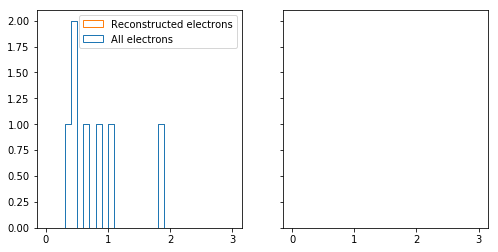

In [18]:
electron_energy_reco = mc_daughters[b'mc_nu_daughter_energy'][mask_mcfv][electron_reco_mask].content
electron_energy_all = mc_daughters[b'mc_nu_daughter_energy'][mask_mcfv][electron_mask].content

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,4), sharex=True, sharey=True)

ax[0].hist([electron_energy_all,electron_energy_reco], histtype='step', label = ['All electrons', 'Reconstructed electrons'], range=(0,3), bins=30 )
ax[0].legend()

ax[1].hist(matched_electron_energy, histtype='step', label = 'Daughter energies', range=(0,3), bins=30 )
ax[1].hist(electron_energy_reco, histtype='step', label = 'Reconstructed electrons', range=(0,3), bins=30 )
ax[1].legend()

In [20]:
plt.hist(nuecc_events.array('mc_nu_vtx_distance')[mask_mcfv], bins=100,range=(0,5))
mask_mcfv_1cm = nuecc_events.array(b'mc_nu_vtx_distance')[mask_mcfv]<1
fraq = sum(mask_mcfv_1cm)/num_selected_fidvol*100
print("Percent of selected events with vertex within 1cm:",fraq)
plt.title(r"Reconstructed vertex 3D distance for $\nu_e$ intrinsic")
plt.xlabel('distance from true vertex [cm]')
plt.ylabel('events per bin [cm]')
plt.text(2,800,"Within 1cm: {0:.1f}%".format(fraq), fontsize=12)

Percent of selected events with vertex within 1cm: 0.0


Text(2,800,'Within 1cm: 0.0%')

ValueError: Image size of 404x1581545 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

In [21]:
mask_mcfv_pure = nuecc_events.array('cosmic_matched')[mask_mcfv]
# Mask means that the true vertex was within the fiducial volume, is reconstructed within 1cm and no daughters are cosmic matched
mask_mc_ok = ~mask_mcfv_pure & mask_mcfv_1cm
print(len(mask_mc_ok))
print(sum(mask_mc_ok))
print(sum(mask_mc_ok)/len(mask_mc_ok))

7
0
0.0


uint32


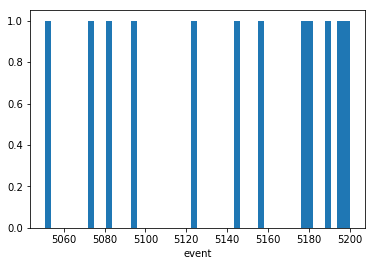

uint32


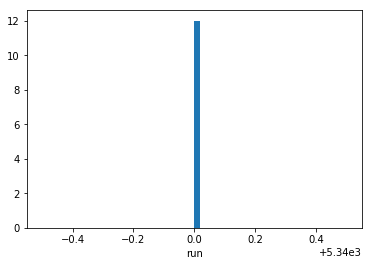

uint32


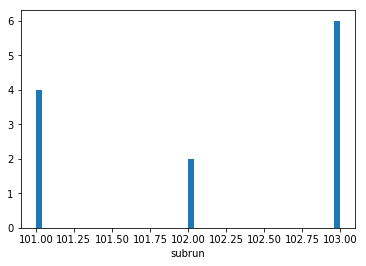

uint32


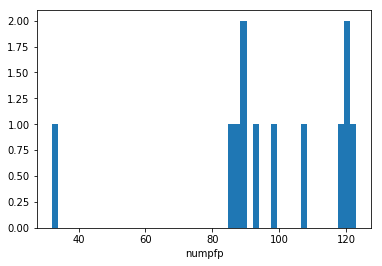

uint32


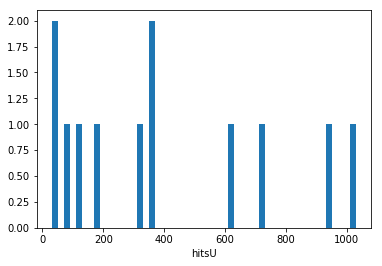

uint32


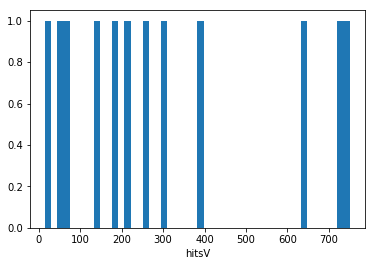

uint32


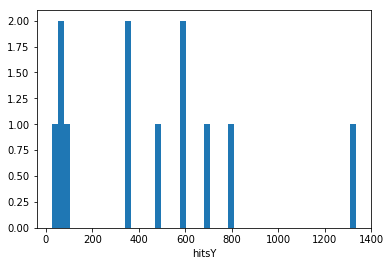

uint32


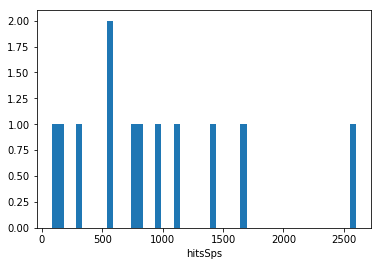

uint32


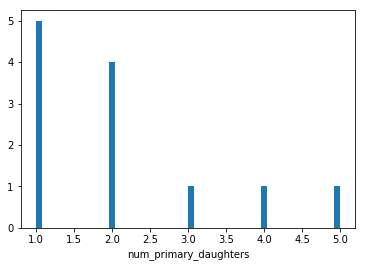

uint32


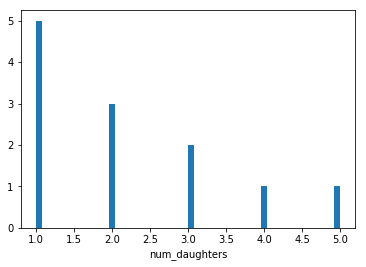

uint32


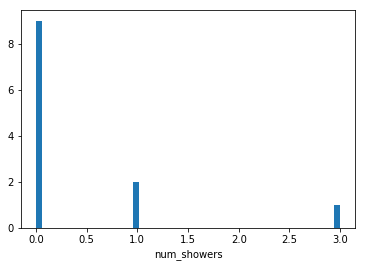

uint32


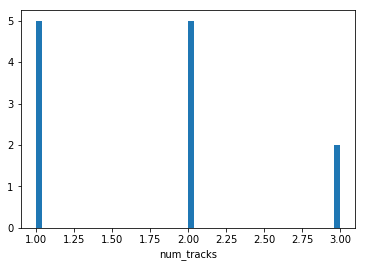

bool


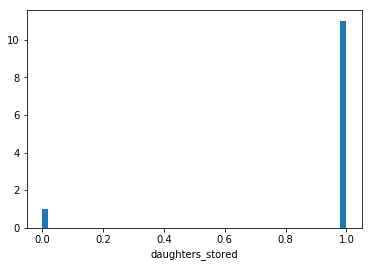

float32


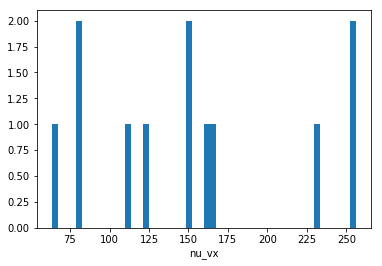

float32


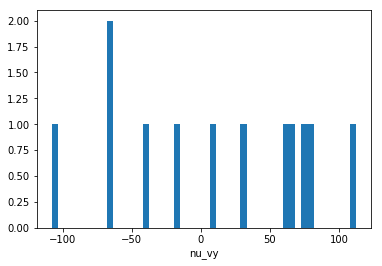

float32


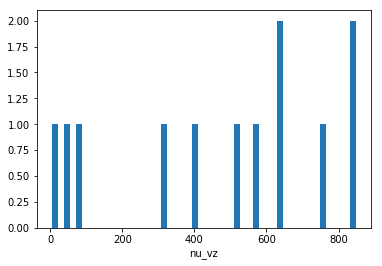

int32


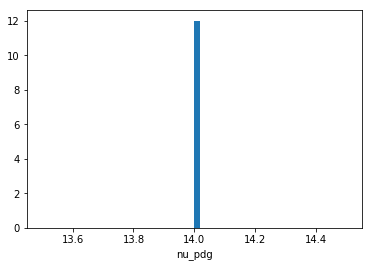

uint32


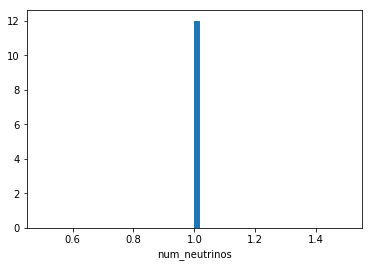

float32


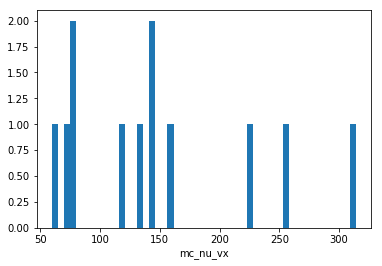

float32


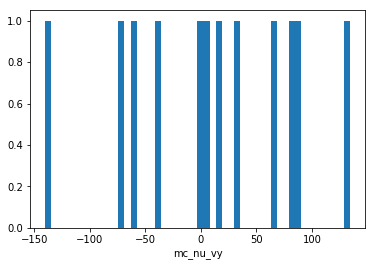

float32


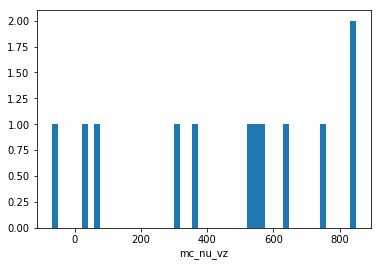

float32


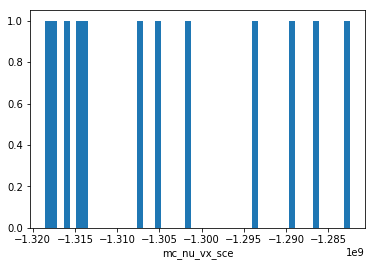

float32


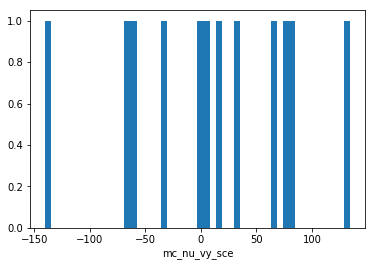

float32


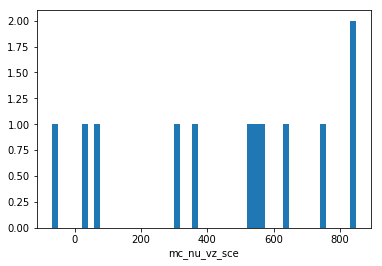

float32


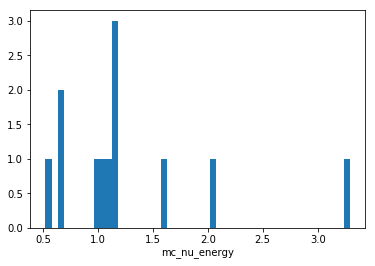

float32


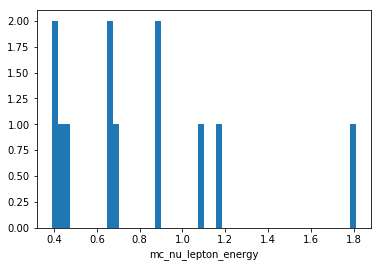

float32


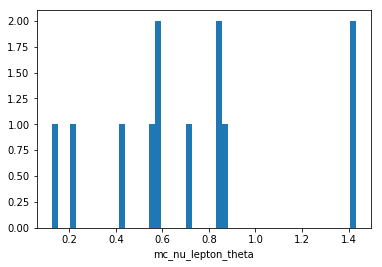

float32


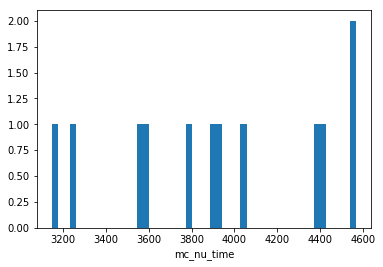

int32


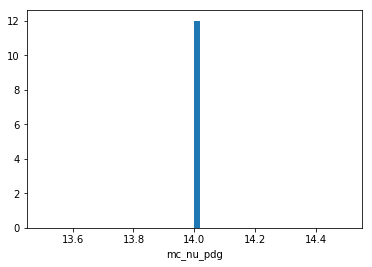

int32


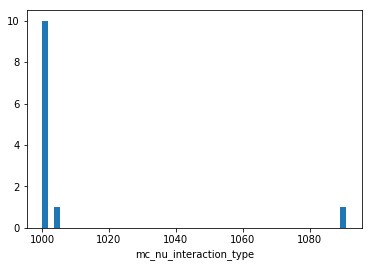

bool


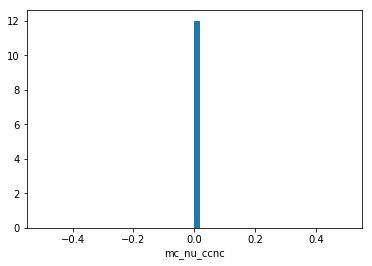

float32


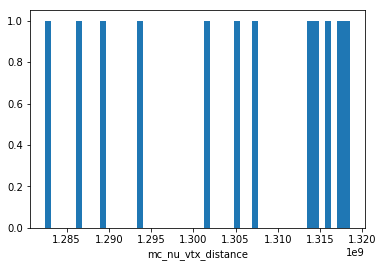

uint32


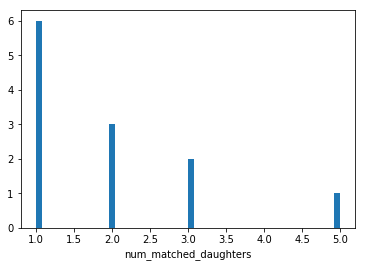

bool


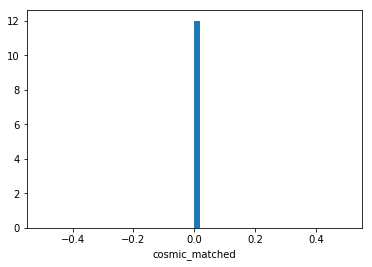

object
object
object


In [22]:
for key in nuecc_events.keys():
    field = nuecc_events.array(key)
    print(field.dtype)
    if field.dtype == np.bool:
        field = 1*field
    if field.dtype == object:
        continue
    plt.hist(field, bins=50)
    plt.xlabel(key.decode("utf-8"))
    plt.show()

In [23]:
# Aantal events met dochter(s) die geen match hadden, ondanks dat de dochter opgeslagen is.
unmatched_daughters = nuecc_events.array(b'num_daughters')-nuecc_events.array(b'num_matched_daughters')
sum((unmatched_daughters==0)*1-1*nuecc_events.array(b'daughters_stored'))

-2

## Reconstructed daughters 

In [24]:
hash_events = eventHash(nuecc_events.pandas.df(['event', 'run', 'subrun', 'numpfp']))
hash_fidvol = dictionary = dict(zip(hash_events, mask_mcfv))

In [25]:
df_daughters = nuecc_daughters.pandas.df()
df_daughters['broken_pfp'] = df_daughters.duplicated(subset=['mc_energy', 'mc_vx', 'mc_vy', 'mc_vz'], keep=False)
df_daughters['event_hash'] = eventHash(df_daughters[['event', 'run', 'subrun', 'numpfp']])
df_daughters['mc_nu_fidvol'] = df_daughters['event_hash'].map(hash_fidvol)

In [26]:
df_daughters.head(15)

,event,run,subrun,numpfp,hitsU,hitsV,hitsY,hitsSps,generation,track_score,is_shower,is_track,has_shower_daughter,is_track_daughter,vx,vy,vz,mc_neutrino,mc_vx,mc_vy,mc_vz,mc_vx_sce,mc_vy_sce,mc_vz_sce,mc_energy,mc_pdg,broken_pfp,event_hash,mc_nu_fidvol
0,5051,5340,101,88,356,216,580,1119,2,1.000000,False,True,False,False,163.910034,80.424332,849.039307,True,158.638672,86.378830,849.371582,-1.282479e+09,80.224792,849.156921,1.072356,13,False,-4629487884832513869,True
1,5073,5340,101,119,604,142,690,1407,2,1.000000,False,True,False,False,78.426575,110.161552,403.305420,True,79.737175,133.943420,369.286011,-1.286399e+09,133.943420,369.286011,0.893851,13,True,-3366605135273365626,False
2,5073,5340,101,119,16,5,0,20,2,0.836143,False,True,False,False,78.382759,112.539833,400.165588,True,79.737175,133.943420,369.286011,-1.286399e+09,133.943420,369.286011,0.893851,13,True,-3366605135273365626,False
3,5083,5340,101,120,86,539,471,773,2,0.999961,False,True,False,False,232.659485,14.499506,38.130718,True,226.803284,14.853570,30.059517,-1.289602e+09,14.384757,38.652290,0.877618,13,False,5596947923752566899,True
4,5095,5340,101,108,298,395,84,542,2,0.743972,False,True,False,False,82.046478,-65.740128,309.011810,True,77.755028,-63.012253,309.598114,-1.293823e+09,-61.756786,309.678894,0.428354,13,False,2215041119789477155,True
5,5095,5340,101,108,15,0,15,29,2,0.790384,False,True,False,False,82.126053,-65.178955,312.383301,True,77.755028,-63.012253,309.598114,-1.293823e+09,-61.756786,309.678894,1.037107,2212,True,2215041119789477155,True
6,5123,5340,102,99,904,308,317,23,2,1.000000,False,True,False,False,155.397293,-13.850476,694.281738,True,77.755028,-63.012253,309.598114,-1.293823e+09,-61.756786,309.678894,1.037107,2212,True,-1080951380180923457,True
7,5123,5340,102,99,96,355,473,845,2,0.999984,False,True,True,False,121.423912,-67.585709,526.315247,True,116.393288,-70.774651,526.207947,-1.301398e+09,-67.733337,526.148926,0.459835,13,True,-1080951380180923457,True
8,5123,5340,102,99,31,71,19,83,3,0.125525,True,False,False,True,131.577667,-17.909346,668.400024,True,116.393288,-70.774651,526.207947,-1.301398e+09,-67.733337,526.148926,0.459835,13,True,-1080951380180923457,True
9,5144,5340,102,89,172,65,350,548,2,0.999863,False,True,False,False,110.730835,-19.510635,4.174397,True,70.446045,1.341539,-68.807816,-1.305355e+09,1.341539,-68.807816,0.668526,13,False,3939898858941429208,False


In [ ]:
len(df_daughters.query('mc_pdg==11 & mc_neutrino & ~broken_pfp'))

In [ ]:
matched_electron_energy = df_daughters.query('abs(mc_pdg)==11 & mc_neutrino & mc_nu_fidvol').drop_duplicates(subset=['mc_pdg', 'mc_energy', 'mc_energy', 'mc_vx', 'mc_vy', 'mc_vz'])['mc_energy']

In [ ]:
len(matched_electron_energy)